In [1]:
import os
import pandas as pd
import json
import numpy as np
from visualization_ecg import  plot_ecg_fiducial_points, plot_ecg_fiducial_points, plot_original_ecg
from fiducial_point_detection import find_fiducial_points, find_R, butterworth_bandpass_filter, signal_average, normalization, find_fiducial_points_neurokit2
import matplotlib.pyplot as plt
import neurokit2 as nk

In [2]:
import os
# Encontrar directoria de trabajo 
cwd=os.getcwd()
# Path de datos de arritmia
path_ecg_arritmia=os.path.join(cwd, 'MIMIC_arritmia.txt')

In [3]:
def load_data_arrhythmia(file_path):
    ecg=pd.read_csv(file_path,sep=" ",index_col=0)
    # Se transponen los datos 
    ecg=ecg.transpose()
    # Se modifican los índices para que sean de 0 a len(ecg)
    ecg.index = list(range(len(ecg)))
    #ecg1=ecg_70.iloc[1]
    return ecg

In [4]:
"""
Definición de funciones para realizar medidas en el ECG
"""
# Duración de la onda P
def duracion_P(paciente, fs):
    duracion_P = []
    
    P1=paciente['ECG_P_Onsets']
    P2=paciente['ECG_P_Offsets']    

    for i,j in zip(P1,P2):
        if np.isnan(i) == True or np.isnan(j) == True:
            continue
        duracion_p = (j-i)/fs
        duracion_P.append(duracion_p*1000)
        
    return duracion_P 

# Amplitud onda P
def amplitud_P(paciente, signal, fs):
    ECG = signal
    amplitud_P = []
    
    P = paciente['ECG_P_Peaks']
    P2 = paciente['ECG_P_Offsets']

    for (i,j) in zip(P,P2):
        if np.isnan(i) == True or np.isnan(j) == True:
            continue
        amplitud_p = ECG[i]
        amplitud_p2 = ECG[j]      
        amplitud_P.append(amplitud_p - amplitud_p2)
    
    return amplitud_P

def amplitud_P2(paciente, signal):
    amplitud = peak_prominences(signal, fiducial['ECG_P_Peaks'], wlen=None)
    return amplitud[0]

# Duración complejo QRS
def duracion_QRS(paciente,fs):
    duracion_QRS = []
    Q = paciente['ECG_Q_Peaks']
    S = paciente['ECG_S_Peaks']
    
    for i,j in zip(Q,S):
        if np.isnan(i) == True or np.isnan(j) == True:
            continue
        duracion_qrs = (j-i)/fs
        duracion_QRS.append(duracion_qrs*1000)
        
    return duracion_QRS

# Amplitud T
def amplitud_T(paciente, signal, fs):
    ECG = signal
    amplitud_T = []
    
    T = paciente['ECG_T_Peaks']
    T2 = paciente['ECG_T_Offsets']
   
    for i,j in zip(T,T2):
        if np.isnan(i) == True or np.isnan(j) == True:
            continue
        amplitud_t = ECG[i]
        amplitud_t2 = ECG[j]
        amplitud_T.append(amplitud_t - amplitud_t2)
 
    return amplitud_T

# Bloqueo AV
# Cuando la duración del segmento PR < 200 ms
def duracion_PR(paciente,fs):
    duracion_PR=[]
    P1=paciente['ECG_P_Onsets']
    R=paciente['ECG_R_Peaks']
    
    for i,j in zip(P1,R):
        if np.isnan(i) == True or np.isnan(j) == True:
            continue
        duracion_pr = (j-i)/fs
        duracion_PR.append(duracion_pr*1000)
        
    #duracion_PR = [x for x in duracion_PR if ~np.isnan(x)]
    return duracion_PR

# Latido atrial prematuro
# Cuando amplitud de P1 y amplitud de P2 son diferentes

def amplitud_P1_P2(paciente,signal,fs):
    amplitud_P1 = []
    amplitud_P2 = []
    ECG = signal
    P1 = paciente['ECG_P_Onsets']
    P2 = paciente['ECG_P_Offsets']
   
    for i,j in zip(P1,P2):
        if np.isnan(i) == True or np.isnan(j) == True:
            continue
        amplitud_p1 = ECG[i]
        amplitud_p2 = ECG[j]
        amplitud_P1.append(amplitud_p1)
        amplitud_P2.append(amplitud_p2)

    return amplitud_P1, amplitud_P2

# Calculo de la frecuencia cardíaca y duracion RR
def HR_mean(paciente,fs):  
    """
    Calculo de los intervalos RR, para determinar la frecuencia cardíaca promedio de cada ECG
    
    Parámetros:
    -----------
    R = paciente a analizar
    fs = int
        Frecuencia de muestreo
    Return
    -----------
    Frecuencia cardíaca media
    """
    R=paciente['ECG_R_Peaks']

    RR=[]
    HR=[]
    for ind in range(len(R)-1):
        RR.append(R[ind+1]/fs - R[ind]/fs)
        HR.append(1/(R[ind+1]/fs - R[ind]/fs)*60)
    HR_mean=round(np.mean(HR))
    RR = list(map(lambda x: x * 1000, RR))
    RR =  np.round(RR,3)
    RR = [x for x in RR if ~np.isnan(x)]
    return HR_mean, RR

In [11]:
"""
TAXONOMY
"""

def taxonomy(paciente, signal, fs):    
        
    # La onda P debe durar menos de 120 ms
    duracionP = np.mean(duracion_P(paciente,fs))
    print('Duración onda P = {} ms'.format(round(duracionP,2)))
    
    # La amplitud de la onda P debe ester entre 0.15 y 0.2 mV
    amplitudP = np.mean(amplitud_P(paciente,signal, fs))
    print('Amplitud onda P = {} mV'.format(round(amplitudP,2)))
    
    # La duración del complejo QRS debe estar entre 80 y 120 ms
    duracionQRS = np.mean(duracion_QRS(paciente,fs))
    print('Duración de QRS = {} ms'.format(round(duracionQRS,2)))
    
    # La amplitud de la onda T debe ser positiva
    amplitudT = np.mean(amplitud_T(paciente,signal,fs))
    print('Amplitud onda T = {} mV'.format(round(amplitudT,2)))
    
    # El segmento PR debe durar menos de 200 ms 
    duracionPR = np.mean(duracion_PR(paciente, fs))
    print('Duración segmento PR = {} ms'.format(round(duracionPR,2)))
    
    amplitudP1, amplitudP2 = amplitud_P1_P2(paciente,signal,fs)
    amplitudP1 = np.mean(amplitudP1)
    amplitudP2 = np.mean(amplitudP2)
    print('Amplitud P1 = {} y P2 = {} mV'.format(round(amplitudP1,2),round(amplitudP2,2)))
    
    # HRmean esta normal entre 60 y 100 ms, RR dura entre 600 y 1200 ms
    HRmean, RR = HR_mean(paciente,fs)
    print('Frecuencia cardíaca = {}'.format(round(HRmean,2)))
    print(HRmean)
    
    # El intervalo RR debe ser regular
    diffRR = np.diff(RR)
    
    sano = True
    
    if duracionPR > 200:
        print('Bloqueo AV \n')
        sano = False
    
    if (amplitudP1 - amplitudP2) > 0.05:
        print('Latido atrial prematuro \n')
        sano = False
    
    if duracionQRS > 120:
        print('Bloqueo de rama \n')
        sano = False
    
    if HRmean < 60:
        print('Bradicardia \n')
    
    if HRmean > 100:
        print('Taquicardia')
        if  duracionQRS < 120:
            print('Taquicardia supraventricular \n')
        sano = False
        
    if sano == True:
        print('sano')
             

# Determinar el mejor detector de puntos fiduciales

El objetivo de esta celda es determinar que algoritmo ubica con mayor precisión los puntos fiduciales de los ECG, para esto se visualiza el mismo ECG pero entres casos:
1. ECG original
2. Detección de los puntos fiduciales con el algortimo de R (ECG se encuentra filtrado y normalizado)
3. Detección de los puntos fiduciales con la librería Neurokit2 (ECG se encuentra filtrado y normalizado)

Los puntos fiduciales son los siguientes:

- Color rojo corresponde a las onda P
- Color verde al complejo QRS
- Color azul onda T
- Color cyan punto J
- Triangulo marca el inicio de la onda
- Circulo marca el pico de la onda
- Triangulo invertido marca el final de la onda

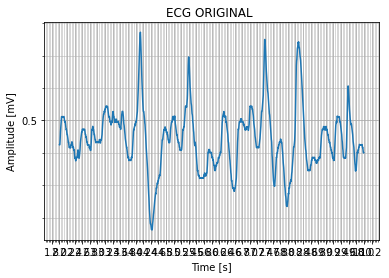

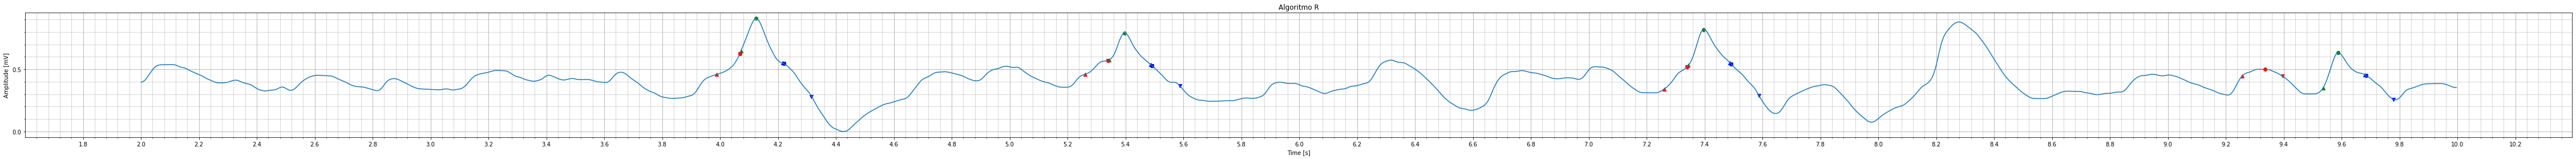

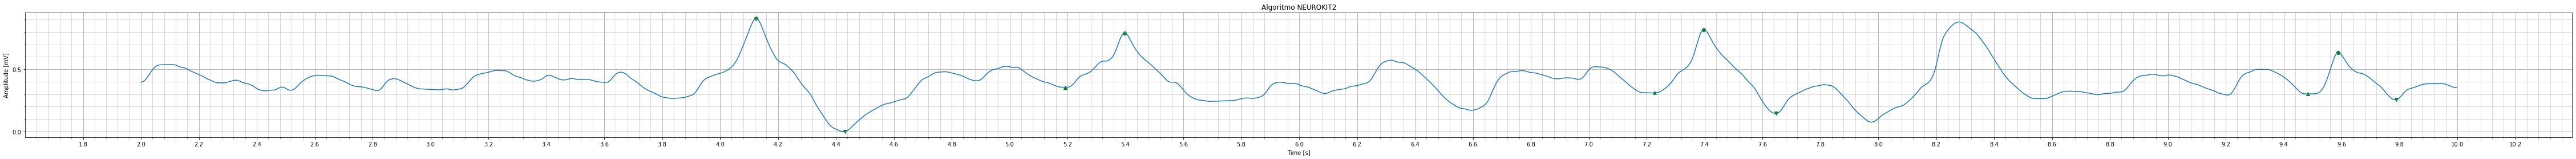

In [7]:
# Estos tiene una fs= 250,  Wn_low = 60 y Wn_high = 0.5
signals = load_data_arrhythmia(path_ecg_arritmia)

# id corresponde al paciente que quiero analizar, por ejemplo el paciente 0 seria id=0,
# en total son 282, es decir hasta id = 281
id = 8
signal = signals.iloc[id]

# Frecuencia de muestreo
fs=250

# Frecuencia de corte de los filtros
Wn_low = 60
Wn_high = 0.5

# Parametros para detección de los puntos fiduciales respecto a picos R
gr_r = 0.8
gr2 = 0.1 * fs # max number of samples for RS distance  
gr3 = 0.32 * fs # max number of samples for ST distance = 0.32[s]*fs #640
gr4 = 0.05 * fs # max QR distance
gr5 = 0.2 * fs # max PQ distance
gr6 = 0.08 *fs # max PP1 distance (P1 - beginning of P wave) 
gr7 = 0.065 * fs  # max PP2 distance (P2 - end of P wave)
gr8 = 0.1 * fs # max TT1 distance (T1 - beginning of T wave)
gr9 = 0.1 * fs # max of TT2 distance (T2 - end of T wave)
gr10 = 0.04 * fs # max of SS2 distance (S2 - end of QRS complex)

# Filtrado de la señal
#signal_filtered = butterworth_bandpass_filter(signal, Wn_low, Wn_high, fs, 3)
signal_filtered = nk.ecg_clean(signal, sampling_rate=fs, method="neurokit")

# Normalización de la señal
signal_normalized = normalization(signal_filtered)

# Ubicación de los picos R en la señal
#locs_R = find_R(signal_normalized, height=0.8, distance=0.3*fs, fs=fs)

# Promediado de la señal
#signal_av = signal_average(signal_normalized, locs_R, fs) 

# Extracción de puntos fiduciales de la señal
fiducial = find_fiducial_points(signal_normalized,fs,gr_r,gr2,gr3,gr4,gr5,gr6,gr7,gr8,gr9,gr10)
fiducial_nk = find_fiducial_points_neurokit2(signal_normalized,gr_r, fs)

# Para visualizar la señal original normalizada (si se desea ver la señal sin normalizar, es necesarios cambiar
# en la siguiente linea de codigo signal_normalized por signal_filtered)

# t_start corresponde al segundo donde se desea empezar a ver el ecg
# y t_end al segundo donde se desea terminar la visualización del ecg (la maxima duración de estos es de 100 seg)
t_start = 2
t_end = 10

plot_original_ecg(signal,t_start,t_end,fs)
plt.show()

# Visualización de la señal filtrada y normalizada con sus respectivos puntos fiduciales, mediante el algoritmo de R
titulo1 = 'Algoritmo R'
plot_ecg_fiducial_points(fiducial,t_start,t_end,fs,titulo1)
plt.show()

# Visualización de la señal filtrada y normalizada con sus respectivos puntos fiduciales, mediante NEUROKIT 
titulo2 = 'Algoritmo NEUROKIT2'
plot_ecg_fiducial_points(fiducial_nk,t_start,t_end,fs,titulo2)


# Determinar el mejor algoritmo para realizar la taxonomía
El objetivo de esta celda es determinar que puntos fiduciales permiten realizar una mejor medida de características de las ondas

In [16]:
# con esta función tenemos la taxonomía de la señal que se desea analizar
# donde se imprimen las medidas de amplitud y duración de los puntos fiduciales
# y finalmente se imprime el tipo de arritmia
print('MEDIDAS CON ALGORITMO R')
taxonomy(fiducial,signal,fs)

print('\n-----------------------------------\n')
print('MEDIDAS CON NEUROKIT')
taxonomy(fiducial_nk,signal,fs)

MEDIDAS CON ALGORITMO R
Duración onda P = 80.66 ms
Amplitud onda P = 0.0 mV
Duración de QRS = 102.28 ms
Amplitud onda T = 0.02 mV
Duración segmento PR = 167.5 ms
Amplitud P1 = 0.44 y P2 = 0.45 mV
Frecuencia cardíaca = 100
100
sano

-----------------------------------

MEDIDAS CON NEUROKIT
Duración onda P = 50.47 ms
Amplitud onda P = 0.01 mV
Duración de QRS = 209.73 ms
Amplitud onda T = 0.01 mV
Duración segmento PR = 182.33 ms
Amplitud P1 = 0.44 y P2 = 0.44 mV
Frecuencia cardíaca = 100
100
Bloqueo de rama 

